# 1D VTI comparison between `emg3d` and `empymod` in the Laplace domain

The code `empymod` is an open-source code which can model CSEM responses for a layered medium including VTI electrical anisotropy, see https://empymod.github.io.

1. **Full-space VTI model for a finite length, finite strength, rotated bipole.**
2. **Layered model for a deep water model with a point dipole source.**


Both codes, `empymod` and `emg3d`, are able to calculate the EM response in the Laplace domain, by using a real value $s$ instead of the complex value $\mathrm{i}\omega=2\mathrm{i}\pi f$. To calculate the response in the Laplace domain in the two codes you have to provide negativ valuse for the `freq`-parameter, which are then considered `s-value`. 

**Important:** This is in development, and none of this code is in an official release just now. Currently, you need to use:
- `empymod`: `lplc`-branch (the feature should land in `empymod v1.9.0`);
- `emg3d`: `master`-branch (the feature should land in `emg3d v.0.8.0`).

#### Requires
- ``emg3d``, ``discretize``, ``empymod``
- ``numpy``, ``scipy``, ``numba``, ``matplotlib``

In [1]:
import emg3d
import empymod
import discretize
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as sint
from matplotlib.colors import LogNorm, SymLogNorm

In [2]:
# Style adjustments
%matplotlib inline
plt.style.use('ggplot')

### Plotting and interpolation routines

In [3]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map
    https://gist.github.com/jakevdp/91077b0cae40f8f8244a
    """
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


def plot_data_rel(ax, name, data, x, vmin=-15., vmax=-7., error=False):
    """Plot function."""
    
    ax.set_title(name)
    ax.set_xlim(min(x)/1000, max(x)/1000)
    ax.set_ylim(min(x)/1000, max(x)/1000)
    ax.axis("equal")
    
    if error:
        cf = ax.pcolormesh(x/1000, x/1000, np.log10(data), vmin=vmin, vmax=vmax,
                           linewidth=0, rasterized=True, cmap=discrete_cmap(8, "RdBu_r"))
    else:
        cf = ax.pcolormesh(x/1000, x/1000, np.log10(np.abs(data)), linewidth=0,
                           rasterized=True, cmap="viridis", vmin=vmin, vmax=vmax)

    return cf


def plot_result_rel(depm, de3d, x, title, vmin=-15., vmax=-7.):
    fig, axs = plt.subplots(figsize=(18, 7.5), nrows=1, ncols=3)

    # Plot Re(data)
    cf0 = plot_data_rel(axs[0], r"(a) |empymod|", depm.real, x, vmin, vmax, error=False)
    plot_data_rel(axs[1], r"(b) |emg3d|", de3d.real, x, vmin, vmax, error=False)
    cf2 = plot_data_rel(axs[2], r"(c) Error",
                        np.abs((depm.real-de3d.real)/depm.real)*100, x,
                        vmin=-2, vmax=2, error=True)

    # Colorbars
    fig.colorbar(cf0, ax=axs[:2], label=r"$\log_{10}$ Amplitude (V/m)", aspect=40, orientation='horizontal')
    cbar = fig.colorbar(cf2, ax=axs[2], label=r"Relative Error", orientation='horizontal')
    cbar.set_ticks([-2, -1, 0, 1, 2])
    cbar.ax.set_yticklabels([r"$0.01\,\%$", r"$0.1\,\%$", r"$1\,\%$", r"$10\,\%$", r"$100\,\%$"])

    # Axis label
    axs[0].set_ylabel("Crossline Offset (km)")
    axs[1].set_xlabel("Inline Offset (km)")

    # Title
    fig.suptitle(title, y=1, fontsize=20)

    
def plot_lineplot_ex(x, y, data, epm_fs, grid):
    xi = x.size//2
    yi = y.size//2
    
    fn = sint.interp1d(x, data[:, xi], bounds_error=False)
    x1 = fn(grid.vectorNx)
    
    fn = sint.interp1d(y, data[yi, :], bounds_error=False)
    y1 = fn(grid.vectorNx)

    plt.figure(figsize=(15, 8))
    
    plt.plot(x/1e3, np.abs(epm_fs[:, xi]), 'C0', lw=3, label='Inline empymod')
    plt.plot(x/1e3, np.abs(data[:, xi]), 'k--', label='Inline emg3d')
    plt.plot(grid.vectorNx/1e3, np.abs(x1), 'k*')
    
    plt.plot(y/1e3, np.abs(epm_fs[yi, :]), 'C1', lw=3, label='Crossline empymod')
    plt.plot(y/1e3, np.abs(data[yi, :]), 'k:', label='Crossline emg3d')
    plt.plot(grid.vectorNx/1e3, np.abs(y1), 'k*', label='Grid points emg3d')

    plt.yscale('log')
    plt.title(r'Inline and crossline $E_x$', fontsize=20)
    plt.xlabel('Offset (km)', fontsize=14)
    plt.ylabel(r'|Amplitude (V/m)|', fontsize=14)
    plt.legend()
    plt.show()

## 1. Full-space VTI model for a finite length, finite strength, rotated bipole 

### `empymod`

In [4]:
# Survey parameters
x = (np.arange(1025))*5-2560
rx = np.repeat([x,],np.size(x),axis=0)
ry = rx.transpose()

# Model parameters
resh = 1.              # Horizontal resistivity
aniso = np.sqrt(2.)    # Anisotropy
resv = resh*aniso**2   # Vertical resistivity
src = [-50, 50, -30, 30, -320., -280.]  # Source: [x1, x2, y1, y2, z1, z2]
src_c = np.mean(np.array(src).reshape(3, 2), 1).ravel()  # Center points of course
zrec = -400.           # Receiver depth
sval = -4.84           # Laplace-value
strength = np.pi       # Source strength

# Input for empymod
model = {  # empymod has positive z-down, so switch source-z
    'src': [src[0], src[1], src[2], src[3], -src[4], -src[5]],
    'depth': [],
    'res': resh,
    'aniso': aniso,
    'strength': strength,
    'srcpts': 5,
    'freqtime': sval,
    'htarg': {'pts_per_dec': -1},
}

In [5]:
epm_fs_x = empymod.bipole(rec=[rx.ravel(), ry.ravel(), -zrec, 0, 0], verb=3, **model).reshape(np.shape(rx))
epm_fs_y = empymod.bipole(rec=[rx.ravel(), ry.ravel(), -zrec, 90, 0], verb=1, **model).reshape(np.shape(rx))
epm_fs_z = empymod.bipole(rec=[rx.ravel(), ry.ravel(), -zrec, 0, -90], verb=1, **model).reshape(np.shape(rx))


:: empymod START  ::

   depth       [m] :  
   res     [Ohm.m] :  1
   aniso       [-] :  1.41421
   epermH      [-] :  1
   epermV      [-] :  1
   mpermH      [-] :  1
   mpermV      [-] :  1

>  MODEL IS A FULLSPACE
   direct field    :  Calc. in wavenumber domain
   s-value    [Hz] :  4.84
   Hankel          :  DLF (Fast Hankel Transform)
     > Filter      :  Key 201 (2009)
     > DLF type    :  Lagged Convolution
   Kernel Opt.     :  None
   Loop over       :  Frequencies
   Source(s)       :  1 bipole(s)
     > intpts      :  5
     > length  [m] :  123.288
     > strength[A] :  3.14159
     > x_c     [m] :  0
     > y_c     [m] :  0
     > z_c     [m] :  300
     > azimuth [°] :  30.9638
     > dip     [°] :  -18.9318
   Receiver(s)     :  1050625 dipole(s)
     > x       [m] :  -2560 - 2560 : 1.05062E+06  [min-max; #]
     > y       [m] :  -2560 - 2560 : 1.05062E+06  [min-max; #]
     > z       [m] :  400
     > azimuth [°] :  0
     > dip     [°] :  0
   Required ab's   : 

### `emg3d`

In [6]:
# Get calculation domain as a function of frequency (resp., skin depth)
hx_min, xdomain = emg3d.utils.get_domain(x0=src[0], freq=0.1, min_width=20)
hz_min, zdomain = emg3d.utils.get_domain(x0=src[2], freq=0.1, min_width=20)

# Create stretched grid
nx = 2**7
hx = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, src_c[0])
hy = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, src_c[1])
hz = emg3d.utils.get_stretched_h(hz_min, zdomain, nx, src_c[2])
pgrid = discretize.TensorMesh([hx, hy, hz], x0=(xdomain[0], xdomain[0], zdomain[0]))
pgrid

TensorMesh: 2,097,152 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    128     -4,408.71      4,228.19     20.00    160.52    1.03
   y    128     -4,408.71      4,228.19     20.00    160.52    1.03
   z    128     -4,388.71      4,249.67     20.00    165.56    1.03

In [7]:
# Get the model
pmodel = emg3d.utils.Model(pgrid, res_x=resh, res_z=resv, freq=sval)

# Get the source field
sfield = emg3d.utils.get_source_field(pgrid, src, sval, strength)

# Calculate the electric field
pfield = emg3d.solver.solver(pgrid, pmodel, sfield, verb=3)


:: emg3d START :: 10:37:54 ::

   MG-cycle       : 'F'                 sslsolver : False
   semicoarsening : False [0]           tol       : 1e-06
   linerelaxation : False [0]           maxit     : 50
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  : 128 x 128 x 128     => 2,097,152 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   6 ;   6 ;   6   

   [hh:mm:ss]  rel. error                  [abs. error, last/prev]   l s

       h_
      2h_ \                                        /
      4h_  \                            /\        / 
      8h_   \                  /\      /  \      /  
     16h_    \          /\    /  \    /    \    /   
     32h_     \    /\  /  \  /    \  /      \  /    
     64h_      \/\/  \/    \/      \/        \/     

   [10:38:04]   2.847e-02  after   1 F-cycles   [1.859e-05, 0.028]   0 0
   [10:38:14]   2.262e-03  after   2 F-cycles   [1.477e-06, 0.079]   0 0
   [10:38:24]   2.617e-04  after   3 F-cycle

### Plot

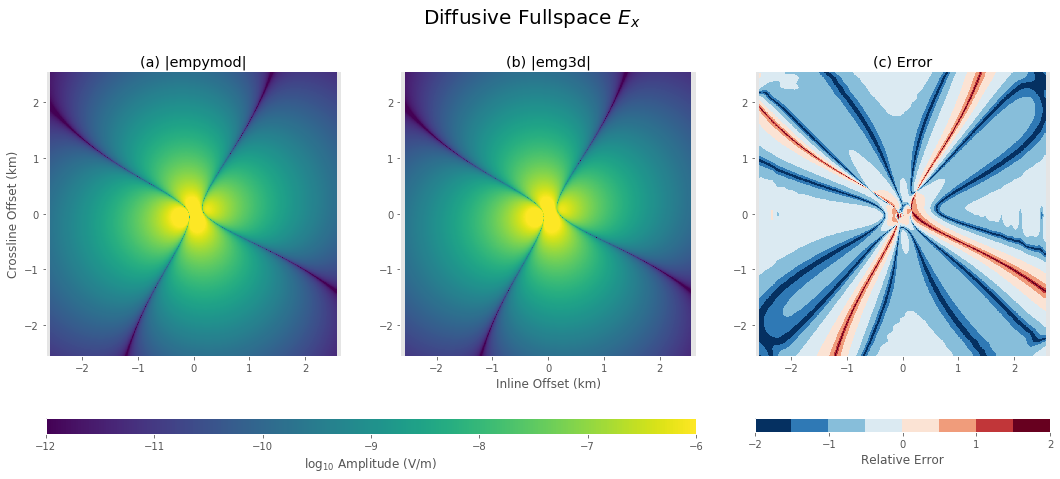

In [8]:
e3d_fs_x = emg3d.utils.get_receiver(pgrid, pfield.fx, (rx, ry, zrec))
plot_result_rel(epm_fs_x, e3d_fs_x, x, r'Diffusive Fullspace $E_x$', vmin=-12, vmax=-6)

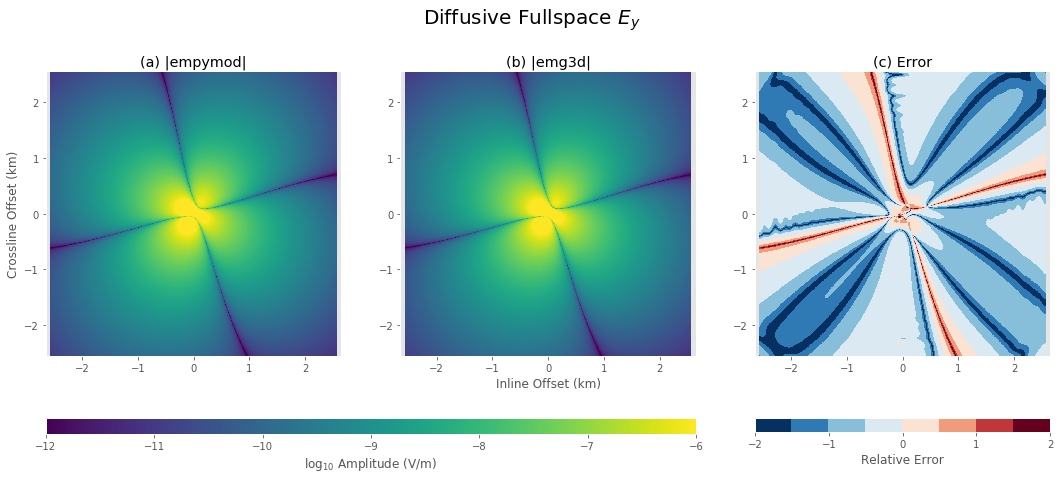

In [9]:
e3d_fs_y = emg3d.utils.get_receiver(pgrid, pfield.fy, (rx, ry, zrec))
plot_result_rel(epm_fs_y, e3d_fs_y, x, r'Diffusive Fullspace $E_y$', vmin=-12, vmax=-6)

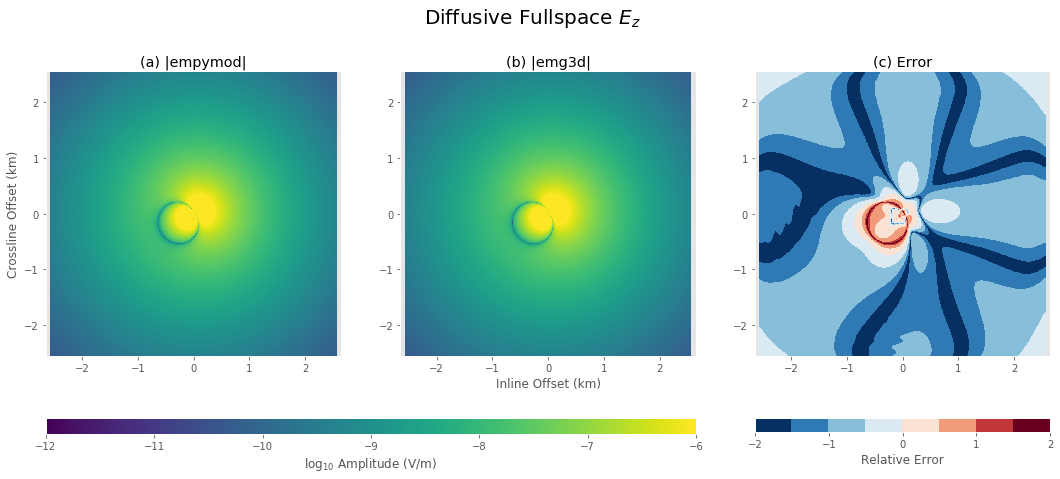

In [10]:
e3d_fs_z = emg3d.utils.get_receiver(pgrid, pfield.fz, (rx, ry, zrec))
plot_result_rel(epm_fs_z, e3d_fs_z, x, r'Diffusive Fullspace $E_z$', vmin=-12, vmax=-6)

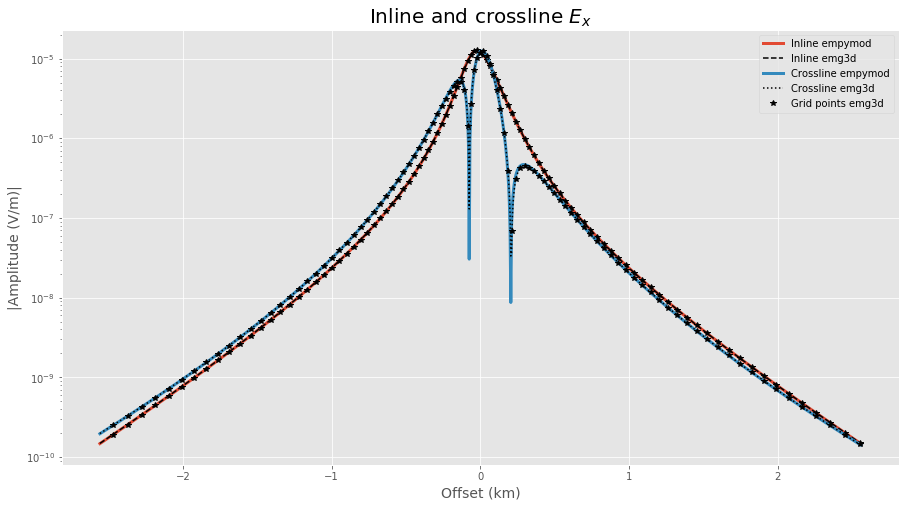

In [11]:
plot_lineplot_ex(x, x, e3d_fs_x.real, epm_fs_x.real, pgrid)

## 2. Layered model for a deep water model with a point dipole source.

### `empymod`

In [12]:
# Survey parameters
x = (np.arange(1025))*5-2560
rx = np.repeat([x,], np.size(x), axis=0)
ry = rx.transpose()

# Model parameters
resh = [2e14, 0.3, 1, 50, 1]      # Horizontal resistivity
aniso = np.sqrt([1, 1, 2, 2, 2])  # Anisotropy
resv = resh*aniso**2              # Vertical resistivity
src = [0, 0, -900, 0, 0]          # Source: [x, y, z, azimuth, dip]
zrec = -950.                      # Receiver depth
sval = -2*np.pi                   # Laplace-value
depth = np.array([0, -1000, -2000, -2200])  # Layer boundaries

model = {  # empymod has positive z-down, so switch source-z
    'src': [src[0], src[1], -src[2], src[3], src[4]],
    'depth': -depth,
    'res': resh,
    'aniso': aniso,
    'freqtime': sval,
    'htarg': {'pts_per_dec': -1},
}

In [13]:
epm_deep_x = empymod.bipole(rec=[rx.ravel(), ry.ravel(), -zrec, 0, 0], verb=3, **model).reshape(np.shape(rx))
epm_deep_y = empymod.bipole(rec=[rx.ravel(), ry.ravel(), -zrec, 90, 0], verb=1, **model).reshape(np.shape(rx))
epm_deep_z = empymod.bipole(rec=[rx.ravel(), ry.ravel(), -zrec, 0, -90], verb=1, **model).reshape(np.shape(rx))


:: empymod START  ::

   depth       [m] :  0 1000 2000 2200
   res     [Ohm.m] :  2E+14 0.3 1 50 1
   aniso       [-] :  1 1 1.41421 1.41421 1.41421
   epermH      [-] :  1 1 1 1 1
   epermV      [-] :  1 1 1 1 1
   mpermH      [-] :  1 1 1 1 1
   mpermV      [-] :  1 1 1 1 1
   direct field    :  Calc. in wavenumber domain
   s-value    [Hz] :  6.28319
   Hankel          :  DLF (Fast Hankel Transform)
     > Filter      :  Key 201 (2009)
     > DLF type    :  Lagged Convolution
   Kernel Opt.     :  None
   Loop over       :  Frequencies
   Source(s)       :  1 dipole(s)
     > x       [m] :  0
     > y       [m] :  0
     > z       [m] :  900
     > azimuth [°] :  0
     > dip     [°] :  0
   Receiver(s)     :  1050625 dipole(s)
     > x       [m] :  -2560 - 2560 : 1.05062E+06  [min-max; #]
     > y       [m] :  -2560 - 2560 : 1.05062E+06  [min-max; #]
     > z       [m] :  950
     > azimuth [°] :  0
     > dip     [°] :  0
   Required ab's   :  11
* WARNING :: Offsets < 0.001 m a

### `emg3d`

In [14]:
# Get calculation domain as a function of frequency (resp., skin depth)
hx_min, xdomain = emg3d.utils.get_domain(x0=src[0], freq=0.1, min_width=20)
hz_min, zdomain = emg3d.utils.get_domain(x0=src[2], freq=0.1, min_width=20, fact_pos=10)

# Create stretched grid
nx = 2**7
hx = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, src[0])
hy = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, src[1])
hz = emg3d.utils.get_stretched_h(hz_min, zdomain, nx*2, x0=depth[-1], x1=0)
pgrid = discretize.TensorMesh([hx, hy, hz], x0=(xdomain[0], xdomain[0], zdomain[0]))
pgrid

TensorMesh: 4,194,304 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    128     -4,358.71      4,505.64     20.00    166.93    1.03
   y    128     -4,358.71      4,505.64     20.00    166.93    1.03
   z    256     -5,258.71      7,568.16     20.00    229.22    1.03

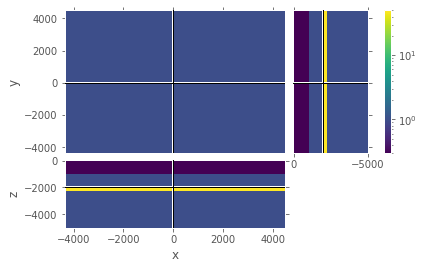

In [15]:
# Create the model: horizontal resistivity
res_x_full =  resh[-1]*np.ones(pgrid.nC)  # Background
res_x_full[pgrid.gridCC[:, 2] >= depth[3]] = resh[3]  # Target
res_x_full[pgrid.gridCC[:, 2] >= depth[2]] = resh[2]  # Overburden
res_x_full[pgrid.gridCC[:, 2] >= depth[1]] = resh[1]  # Water
res_x_full[pgrid.gridCC[:, 2] >= depth[0]] = resh[0]  # Air

# Create the model: vertical resistivity
res_z_full =  resv[-1]*np.ones(pgrid.nC)  # Background
res_z_full[pgrid.gridCC[:, 2] >= depth[3]] = resv[3]
res_z_full[pgrid.gridCC[:, 2] >= depth[2]] = resv[2]
res_z_full[pgrid.gridCC[:, 2] >= depth[1]] = resv[1]
res_z_full[pgrid.gridCC[:, 2] >= depth[0]] = resv[0]

# Get the model
pmodel = emg3d.utils.Model(pgrid, res_x_full, res_z=res_z_full, freq=sval)

# Plot it
pgrid.plot_3d_slicer(pmodel.res_x, zslice=-2000, clim=[0.3, 50], zlim=(-5000, 50), pcolorOpts={'norm': LogNorm()})

In [16]:
# Get the source field
sfield = emg3d.utils.get_source_field(pgrid, src, sval, 0)

# Calculate the electric field
pfield = emg3d.solver.solver(pgrid, pmodel, sfield, verb=3)


:: emg3d START :: 10:40:17 ::

   MG-cycle       : 'F'                 sslsolver : False
   semicoarsening : False [0]           tol       : 1e-06
   linerelaxation : False [0]           maxit     : 50
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  : 128 x 128 x 256     => 4,194,304 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   6 ;   6 ;   7   

   [hh:mm:ss]  rel. error                  [abs. error, last/prev]   l s

       h_
      2h_ \                                                      /
      4h_  \                                        /\          / 
      8h_   \                            /\        /  \        /  
     16h_    \                  /\      /  \      /    \      /   
     32h_     \          /\    /  \    /    \    /      \    /    
     64h_      \    /\  /  \  /    \  /      \  /        \  /     
    128h_       \/\/  \/    \/      \/        \/          \/      

   [10:40:32]   2.549e-02  after   1 F-

### Plot

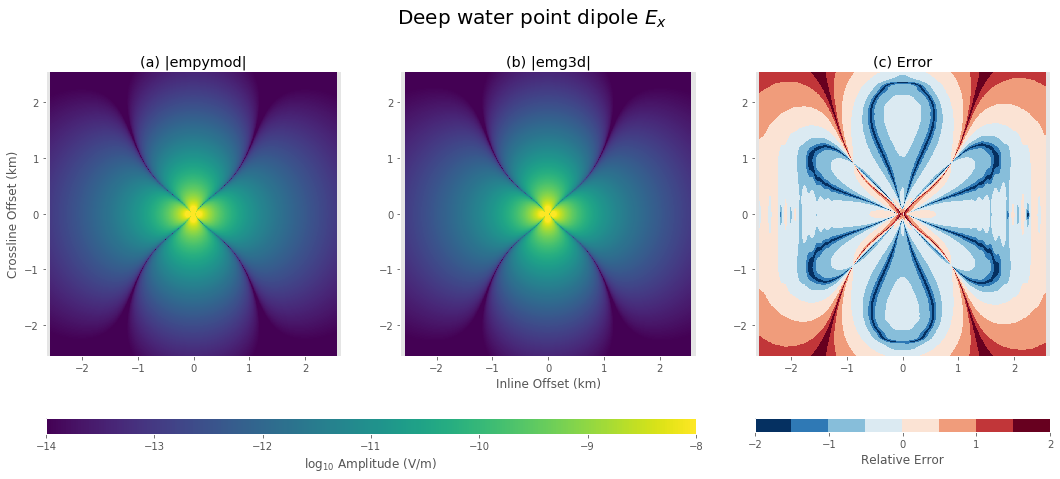

In [17]:
e3d_deep_x = emg3d.utils.get_receiver(pgrid, pfield.fx, (rx, ry, zrec))
plot_result_rel(epm_deep_x, e3d_deep_x, x, r'Deep water point dipole $E_x$', vmin=-14, vmax=-8)

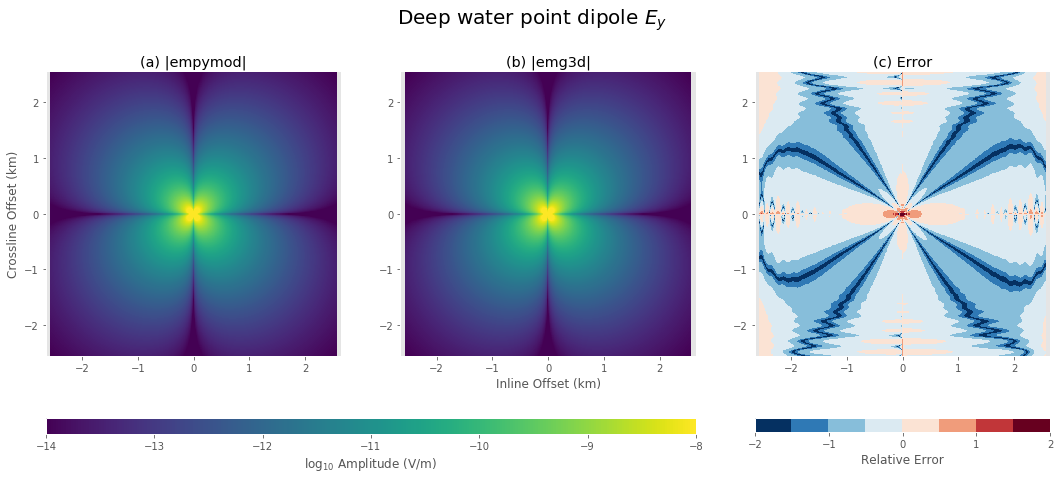

In [18]:
e3d_deep_y = emg3d.utils.get_receiver(pgrid, pfield.fy, (rx, ry, zrec))
plot_result_rel(epm_deep_y, e3d_deep_y, x, r'Deep water point dipole $E_y$', vmin=-14, vmax=-8)

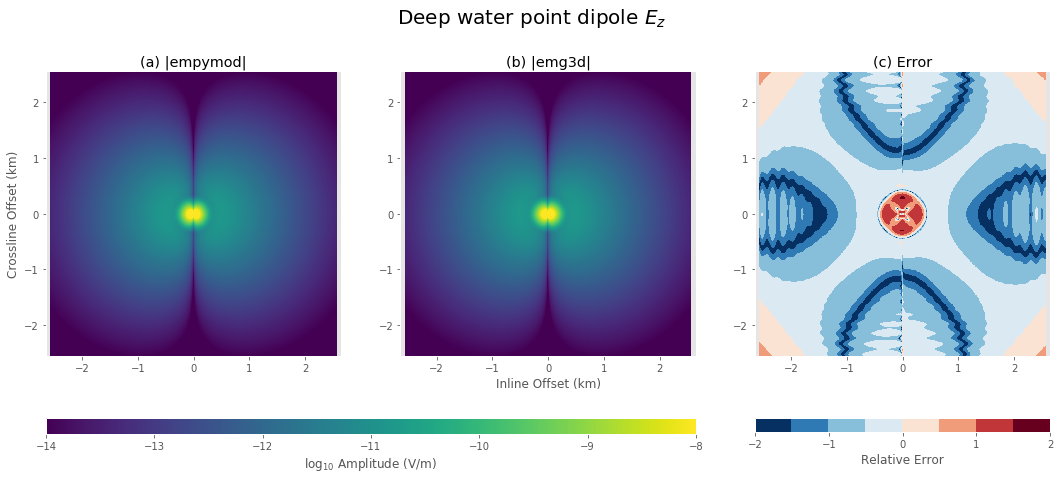

In [19]:
e3d_deep_z = emg3d.utils.get_receiver(pgrid, pfield.fz, (rx, ry, zrec))
plot_result_rel(epm_deep_z, e3d_deep_z, x, r'Deep water point dipole $E_z$', vmin=-14, vmax=-8)

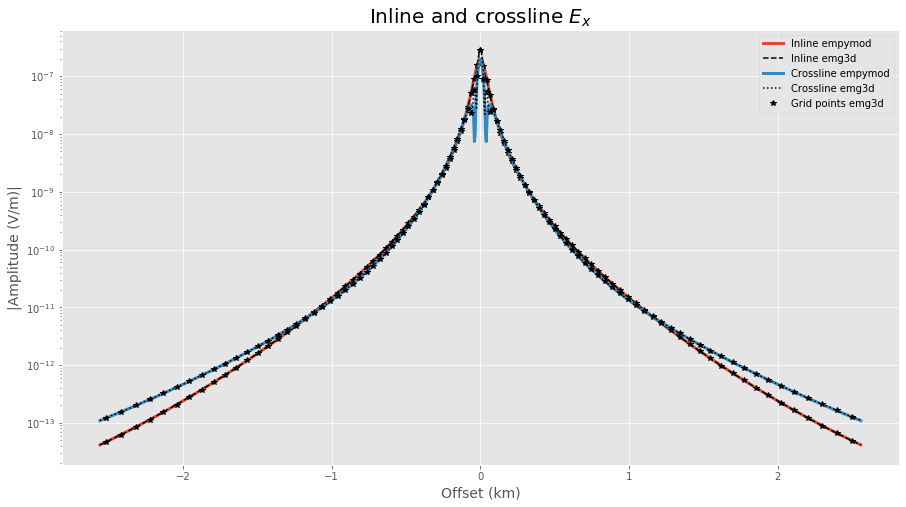

In [20]:
plot_lineplot_ex(x, x, e3d_deep_x.real, epm_deep_x.real, pgrid)

In [21]:
emg3d.Report(empymod)

--------------------------------------------------------------------------------
  Date: Thu Aug 29 10:42:46 2019 CEST

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.5 GB : RAM
           Jupyter : Environment

  Python 3.7.3 (default, Mar 27 2019, 22:11:17)  [GCC 7.3.0]

         1.8.4dev0 : empymod
            1.16.4 : numpy
             1.3.0 : scipy
            0.45.0 : numba
         0.7.2dev0 : emg3d
             7.6.0 : IPython
             3.1.0 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------